## Generator Lirik Lagu atau Puisi Otomatis dengan Menggunakan Arsitektur Model LSTM 3x Layer

### Nama Kelompok
- Muhamad Fadhli Akbar
- Andika Putra Wijaya
- Riski
- Gea

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import re
import string
from collections import Counter
import pickle
import os

In [17]:
# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
Num GPUs Available:  1


In [18]:
def load_poems_dataset(base_path="/content/drive/MyDrive/Colab Notebooks/data"):
    """
    Fungsi untuk load dataset puisi dari folder struktur:
    /content/drive/MyDrive/Colab Notebooks/data/
    ├── folder1/
    │   ├── poem1.txt
    │   ├── poem2.txt
    │   └── ...
    ├── folder2/
    │   ├── poem1.txt
    │   └── ...
    """
    import glob
    from pathlib import Path

    print(f"Loading poems from: {base_path}")

    # Mount Google Drive jika belum di-mount
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive mounted successfully!")
    except:
        print("Not running in Google Colab or Drive already mounted")

    poems = []
    poem_count = 0
    folder_count = 0

    # Baca semua file .txt dari semua subfolder
    if os.path.exists(base_path):
        print(f"Base path exists: {base_path}")

        # Gunakan glob untuk mencari semua file .txt dalam subfolder
        txt_files = glob.glob(os.path.join(base_path, "**", "*.txt"), recursive=True)

        print(f"Found {len(txt_files)} .txt files")

        # Baca setiap file
        for file_path in txt_files:
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                    content = file.read().strip()

                    # Skip file kosong
                    if len(content) > 10:  # Minimal 10 karakter
                        poems.append(content)
                        poem_count += 1

                        # Progress indicator
                        if poem_count % 100 == 0:
                            print(f"Loaded {poem_count} poems...")

            except Exception as e:
                print(f"Error reading {file_path}: {e}")
                continue

        # Hitung jumlah folder
        folders = set()
        for file_path in txt_files:
            folder = os.path.dirname(file_path)
            folders.add(folder)
        folder_count = len(folders)

    else:
        print(f"Path not found: {base_path}")
        print("Please check your path or ensure the data is uploaded to Google Drive")

        # Return sample data jika path tidak ditemukan
        poems = [
            "Roses are red, violets are blue, sugar is sweet, and so are you",
            "The sun sets in the west, painting the sky with golden hues",
            "In the quiet of the night, stars whisper ancient secrets",
            "Mountains stand tall and proud, reaching for the endless sky"
        ]

    print(f"\nDataset loaded successfully!")
    print(f"Total folders: {folder_count}")
    print(f"Total poems: {poem_count}")
    print(f"Average length: {np.mean([len(poem.split()) for poem in poems]):.1f} words")

    return poems

def preview_dataset(poems, num_samples=5):
    """Preview beberapa sample dari dataset"""
    print("\n=== Dataset Preview ===")
    for i, poem in enumerate(poems[:num_samples]):
        print(f"\nPoem {i+1}:")
        print("-" * 40)
        # Tampilkan maksimal 200 karakter pertama
        preview = poem[:200] + "..." if len(poem) > 200 else poem
        print(preview)

    return True

In [19]:
# 3. Preprocessing Data (Updated untuk handling dataset besar)
class TextPreprocessor:
    def __init__(self):
        self.tokenizer = None
        self.vocab_size = 0
        self.max_sequence_length = 0

    def clean_text(self, text):
        """Membersihkan teks dari karakter yang tidak diinginkan"""
        # Convert to lowercase
        text = text.lower()

        # Remove extra whitespace dan newlines
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'\n+', ' ', text)

        # Remove numbers (optional)
        text = re.sub(r'\d+', '', text)

        # Keep only letters, spaces, and basic punctuation
        text = re.sub(r'[^a-zA-Z\s.,!?;:\'\-]', '', text)

        # Remove multiple spaces
        text = re.sub(r'\s+', ' ', text)

        return text.strip()

    def prepare_sequences(self, texts, vocab_size=10000, max_length=40):
        """Mempersiapkan sekuens untuk training dengan optimasi untuk dataset besar"""
        print("Cleaning texts...")

        # Clean texts dengan progress indicator
        cleaned_texts = []
        for i, text in enumerate(texts):
            cleaned = self.clean_text(text)

            # Skip teks yang terlalu pendek
            if len(cleaned.split()) >= 3:
                cleaned_texts.append(cleaned)

            if (i + 1) % 1000 == 0:
                print(f"Cleaned {i + 1}/{len(texts)} texts...")

        print(f"Kept {len(cleaned_texts)} out of {len(texts)} texts after cleaning")

        # Tokenize
        print("Tokenizing texts...")
        self.tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
        self.tokenizer.fit_on_texts(cleaned_texts)

        # Convert to sequences
        print("Converting to sequences...")
        sequences = self.tokenizer.texts_to_sequences(cleaned_texts)

        # Create training sequences
        print("Creating training sequences...")
        input_sequences = []

        for i, sequence in enumerate(sequences):
            # Skip sequences yang terlalu pendek
            if len(sequence) < 3:
                continue

            # Buat multiple sequences dari satu teks
            for j in range(1, min(len(sequence), max_length)):
                input_sequences.append(sequence[:j+1])

            if (i + 1) % 1000 == 0:
                print(f"Processed {i + 1}/{len(sequences)} sequences...")

        print(f"Created {len(input_sequences)} training sequences")

        # Pad sequences
        print("Padding sequences...")
        self.max_sequence_length = max_length
        input_sequences = pad_sequences(input_sequences, maxlen=max_length, padding='pre')

        # Create X and y
        X = input_sequences[:, :-1]
        y = input_sequences[:, -1]

        # Convert y to categorical
        self.vocab_size = min(vocab_size, len(self.tokenizer.word_index) + 1)
        y = to_categorical(y, num_classes=self.vocab_size)

        print(f"Final vocabulary size: {self.vocab_size}")
        print(f"Sequence length: {self.max_sequence_length}")
        print(f"Training samples: {len(X)}")

        return X, y

    def save_tokenizer(self, filepath):
        """Menyimpan tokenizer"""
        with open(filepath, 'wb') as f:
            pickle.dump(self.tokenizer, f)
        print(f"Tokenizer saved to {filepath}")

    def load_tokenizer(self, filepath):
        """Memuat tokenizer"""
        with open(filepath, 'rb') as f:
            self.tokenizer = pickle.load(f)
        print(f"Tokenizer loaded from {filepath}")

In [20]:
# 4. Model LSTM (Updated dengan konfigurasi optimal)
class LSTMLyricGenerator:
    def __init__(self, vocab_size, max_sequence_length, embedding_dim=128):
        self.vocab_size = vocab_size
        self.max_sequence_length = max_sequence_length
        self.embedding_dim = embedding_dim
        self.model = None

    def build_model(self):
        """Membangun model LSTM yang optimal untuk poetry generation"""
        self.model = Sequential([
            Embedding(self.vocab_size, self.embedding_dim, input_length=self.max_sequence_length-1),
            LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
            LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
            LSTM(128, dropout=0.3, recurrent_dropout=0.3),
            Dense(self.vocab_size//2, activation='relu'),
            Dropout(0.5),
            Dense(self.vocab_size, activation='softmax')
        ])

        # Compile dengan learning rate yang optimal
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def train_model(self, X, y, epochs=100, batch_size=64, validation_split=0.2):
        """Melatih model dengan konfigurasi optimal"""
        print("Starting model training...")
        print(f"Training samples: {len(X)}")
        print(f"Validation samples: {int(len(X) * validation_split)}")

        # Callbacks yang lebih sophisticated
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ModelCheckpoint(
                'best_lstm_model.h5',
                save_best_only=True,
                monitor='val_loss',
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=0.0001,
                verbose=1
            )
        ]

        # Training dengan memory optimization
        history = self.model.fit(
            X, y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            callbacks=callbacks,
            verbose=1,
            shuffle=True
        )

        return history

    def generate_text(self, tokenizer, seed_text, num_words=30, temperature=0.8):
        """Generate text dengan improved sampling"""
        result = seed_text.lower()

        for _ in range(num_words):
            # Tokenize current text
            token_list = tokenizer.texts_to_sequences([result])[0]
            token_list = pad_sequences([token_list], maxlen=self.max_sequence_length-1, padding='pre')

            # Predict next word
            predicted_probs = self.model.predict(token_list, verbose=0)[0]

            # Apply temperature for creativity
            if temperature != 1.0:
                predicted_probs = np.log(predicted_probs + 1e-8) / temperature
                predicted_probs = np.exp(predicted_probs)
                predicted_probs = predicted_probs / np.sum(predicted_probs)

            # Sample from top-k to avoid very unlikely words
            top_k = 50
            top_indices = np.argpartition(predicted_probs, -top_k)[-top_k:]
            top_probs = predicted_probs[top_indices]
            top_probs = top_probs / np.sum(top_probs)

            # Sample from distribution
            predicted_index = np.random.choice(top_indices, p=top_probs)

            # Convert back to word
            output_word = ""
            for word, index in tokenizer.word_index.items():
                if index == predicted_index:
                    output_word = word
                    break

            if output_word and output_word != '<OOV>':
                result += " " + output_word
            elif not output_word:
                break  # Stop if no valid word found

        return result

In [21]:
# 5. Fungsi Utama untuk Training (Updated untuk Google Colab)
def main_training(data_path="/content/drive/MyDrive/Colab Notebooks/data"):
    print("=== LSTM Lyric Generator Training ===")

    # Check GPU availability
    print("GPU Available: ", tf.config.list_physical_devices('GPU'))

    # Load data dari Google Drive
    print("Loading dataset from Google Drive...")
    texts = load_poems_dataset(data_path)

    if len(texts) < 10:
        print("Warning: Very small dataset. Consider using a larger dataset for better results.")
        return None, None

    # Preview dataset
    preview_dataset(texts, num_samples=3)

    # Analyze dataset
    analyze_dataset(texts)

    # Preprocessing dengan parameter yang disesuaikan untuk dataset besar
    print("\nPreprocessing data...")
    preprocessor = TextPreprocessor()

    # Sesuaikan parameter berdasarkan ukuran dataset
    vocab_size = min(15000, len(texts) * 10)  # Adaptive vocab size
    max_length = 40  # Optimal untuk poetry

    X, y = preprocessor.prepare_sequences(
        texts,
        vocab_size=vocab_size,
        max_length=max_length
    )

    print(f"\nDataset Statistics:")
    print(f"Vocabulary size: {preprocessor.vocab_size}")
    print(f"Sequence length: {preprocessor.max_sequence_length}")
    print(f"Training samples: {len(X)}")
    print(f"Memory usage: ~{(X.nbytes + y.nbytes) / 1024 / 1024:.1f} MB")

    # Build model
    print("\nBuilding model...")
    generator = LSTMLyricGenerator(
        vocab_size=preprocessor.vocab_size,
        max_sequence_length=preprocessor.max_sequence_length,
        embedding_dim=128
    )

    model = generator.build_model()
    print(model.summary())

    # Calculate optimal batch size based on available memory
    batch_size = 64 if len(X) > 10000 else 32
    epochs = 50 if len(X) > 10000 else 100

    print(f"\nTraining configuration:")
    print(f"Batch size: {batch_size}")
    print(f"Epochs: {epochs}")
    print(f"Estimated training time: {len(X) // batch_size * epochs * 0.1:.1f} seconds")

    # Train model
    print("\nStarting training...")
    history = generator.train_model(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.15
    )

    # Save model and tokenizer to Google Drive
    model_path = "/content/drive/MyDrive/Colab Notebooks/lstm_lyric_generator_model.h5"
    tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"

    generator.model.save(model_path)
    preprocessor.save_tokenizer(tokenizer_path)

    print(f"\nModel saved to: {model_path}")
    print(f"Tokenizer saved to: {tokenizer_path}")

    # Plot training history
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(history.history['lr'] if 'lr' in history.history else [0.001] * len(history.history['loss']))
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('LR')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Test generation
    print("\n=== Testing Generation ===")
    test_seeds = ["love is", "the moon", "flowers bloom"]

    for seed in test_seeds:
        generated = generator.generate_text(
            preprocessor.tokenizer,
            seed,
            num_words=20,
            temperature=0.8
        )
        print(f"Seed: '{seed}' -> {generated}")

    return generator, preprocessor

In [22]:
# 6. Fungsi untuk Generate Lirik (Updated untuk Google Colab)
def generate_lyrics(seed_text="love is", num_words=30, temperature=0.8, model_path=None, tokenizer_path=None):
    """Generate lirik/puisi baru dengan path yang bisa dikustomisasi"""

    # Default paths untuk Google Colab
    if model_path is None:
        model_path = "/content/drive/MyDrive/Colab Notebooks/lstm_lyric_generator_model.h5"
    if tokenizer_path is None:
        tokenizer_path = "/content/drive/MyDrive/Colab Notebooks/tokenizer.pkl"

    try:
        # Load model dan tokenizer
        print(f"Loading model from: {model_path}")
        model = tf.keras.models.load_model(model_path)

        print(f"Loading tokenizer from: {tokenizer_path}")
        preprocessor = TextPreprocessor()
        preprocessor.load_tokenizer(tokenizer_path)

        # Create generator instance
        generator = LSTMLyricGenerator(
            vocab_size=len(preprocessor.tokenizer.word_index) + 1,
            max_sequence_length=40  # Sesuaikan dengan training
        )
        generator.model = model

        # Generate text
        print(f"Generating text with seed: '{seed_text}'")
        generated_text = generator.generate_text(
            preprocessor.tokenizer,
            seed_text,
            num_words=num_words,
            temperature=temperature
        )

        return generated_text

    except Exception as e:
        print(f"Error: {e}")
        print("Pastikan:")
        print("1. Model sudah dilatih dengan menjalankan main_training()")
        print("2. Path model dan tokenizer benar")
        print("3. Google Drive sudah di-mount")
        return None

# Fungsi untuk generate multiple variations
def generate_multiple_lyrics(seed_text="love is", num_variations=5, num_words=25):
    """Generate multiple variations dengan temperature berbeda"""
    print(f"=== Generating {num_variations} variations for '{seed_text}' ===\n")

    temperatures = np.linspace(0.5, 1.2, num_variations)

    for i, temp in enumerate(temperatures, 1):
        print(f"Variation {i} (Temperature: {temp:.2f}):")
        print("-" * 50)

        generated = generate_lyrics(
            seed_text=seed_text,
            num_words=num_words,
            temperature=temp
        )

        if generated:
            print(generated)
        else:
            print("Generation failed")
        print()

    return

In [23]:
# 7. Fungsi untuk Evaluasi Model (Enhanced)
def evaluate_model(model_path=None, tokenizer_path=None):
    """Evaluasi model dengan berbagai seed text dan metrics"""

    print("=== Model Evaluation ===")

    # Test seeds yang beragam
    seed_texts = [
        "love is",
        "the moon",
        "in the night",
        "flowers bloom",
        "time flows",
        "heart beats",
        "stars shine",
        "wind whispers",
        "ocean waves",
        "dreams take flight"
    ]

    temperatures = [0.5, 0.8, 1.0, 1.2]

    print("Generating samples with different temperatures...")
    print("=" * 70)

    for seed in seed_texts[:5]:  # Test 5 seeds untuk tidak terlalu panjang
        print(f"\n🌱 Seed: '{seed}'")
        print("-" * 60)

        for temp in temperatures:
            generated = generate_lyrics(
                seed_text=seed,
                num_words=20,
                temperature=temp,
                model_path=model_path,
                tokenizer_path=tokenizer_path
            )
            if generated:
                print(f"T={temp}: {generated}")
        print()

In [24]:
# 8. Fungsi Helper untuk Analisis (Enhanced)
def analyze_dataset(texts):
    """Analisis dataset yang lebih komprehensif"""
    print("=== Dataset Analysis ===")

    # Basic statistics
    total_texts = len(texts)
    word_lengths = [len(text.split()) for text in texts]
    char_lengths = [len(text) for text in texts]

    total_words = sum(word_lengths)
    avg_words = total_words / total_texts

    print(f"📊 Basic Statistics:")
    print(f"  Total texts: {total_texts:,}")
    print(f"  Total words: {total_words:,}")
    print(f"  Average words per text: {avg_words:.2f}")
    print(f"  Min words per text: {min(word_lengths)}")
    print(f"  Max words per text: {max(word_lengths)}")
    print(f"  Average characters per text: {np.mean(char_lengths):.1f}")

    # Word frequency analysis
    print(f"\n📝 Vocabulary Analysis:")
    all_words = " ".join(texts).lower().split()
    word_freq = Counter(all_words)
    unique_words = len(word_freq)

    print(f"  Unique words: {unique_words:,}")
    print(f"  Vocabulary richness: {unique_words/total_words:.4f}")
    print(f"  Most common words: {word_freq.most_common(15)}")

    # Length distribution
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(word_lengths, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Text Lengths (Words)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.hist(char_lengths, bins=50, alpha=0.7, color='orange', edgecolor='black')
    plt.title('Distribution of Text Lengths (Characters)')
    plt.xlabel('Number of Characters')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    # Top 20 most common words
    common_words = word_freq.most_common(20)
    words, counts = zip(*common_words)
    plt.barh(range(len(words)), counts)
    plt.yticks(range(len(words)), words)
    plt.title('Top 20 Most Common Words')
    plt.xlabel('Frequency')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return word_freq

In [25]:
# 9. Quick Start Guide untuk Google Colab
def colab_quick_start():
    """Panduan cepat untuk memulai di Google Colab"""
    print("🚀 GOOGLE COLAB QUICK START GUIDE")
    print("=" * 50)
    print()
    print("1️⃣ PERSIAPAN:")
    print("   • Upload dataset Poems ke Google Drive di:")
    print("     /content/drive/MyDrive/Colab Notebooks/data/")
    print("   • Pastikan struktur folder berisi file .txt")
    print()
    print("2️⃣ MOUNT GOOGLE DRIVE:")
    print("   from google.colab import drive")
    print("   drive.mount('/content/drive')")
    print()
    print("3️⃣ TRAINING MODEL:")
    print("   generator, preprocessor = main_training()")
    print()
    print("4️⃣ GENERATE LYRICS:")
    print("   result = generate_lyrics('love is', num_words=25, temperature=0.8)")
    print("   print(result)")
    print()
    print("5️⃣ EVALUATE MODEL:")
    print("   evaluate_model()")
    print()
    print("💡 TIPS:")
    print("   • Gunakan GPU Runtime untuk training lebih cepat")
    print("   • Temperature 0.5-0.7: lebih konservatif")
    print("   • Temperature 0.8-1.2: lebih kreatif")
    print("   • Model akan disave otomatis ke Google Drive")


🎵 LSTM LYRIC/POETRY GENERATOR
🚀 GOOGLE COLAB QUICK START GUIDE

1️⃣ PERSIAPAN:
   • Upload dataset Poems ke Google Drive di:
     /content/drive/MyDrive/Colab Notebooks/data/
   • Pastikan struktur folder berisi file .txt

2️⃣ MOUNT GOOGLE DRIVE:
   from google.colab import drive
   drive.mount('/content/drive')

3️⃣ TRAINING MODEL:
   generator, preprocessor = main_training()

4️⃣ GENERATE LYRICS:
   result = generate_lyrics('love is', num_words=25, temperature=0.8)
   print(result)

5️⃣ EVALUATE MODEL:
   evaluate_model()

💡 TIPS:
   • Gunakan GPU Runtime untuk training lebih cepat
   • Temperature 0.5-0.7: lebih konservatif
   • Temperature 0.8-1.2: lebih kreatif
   • Model akan disave otomatis ke Google Drive

INTERACTIVE MODE

Pilih mode:
1. 🏋️ Train new model
2. ✍️ Generate lyrics (requires trained model)
3. 📊 Evaluate model
4. 📈 Analyze dataset
5. 🎲 Generate multiple variations

Choose option (1-5): 1
Enter dataset path (or press Enter for default): 
Starting training with data 

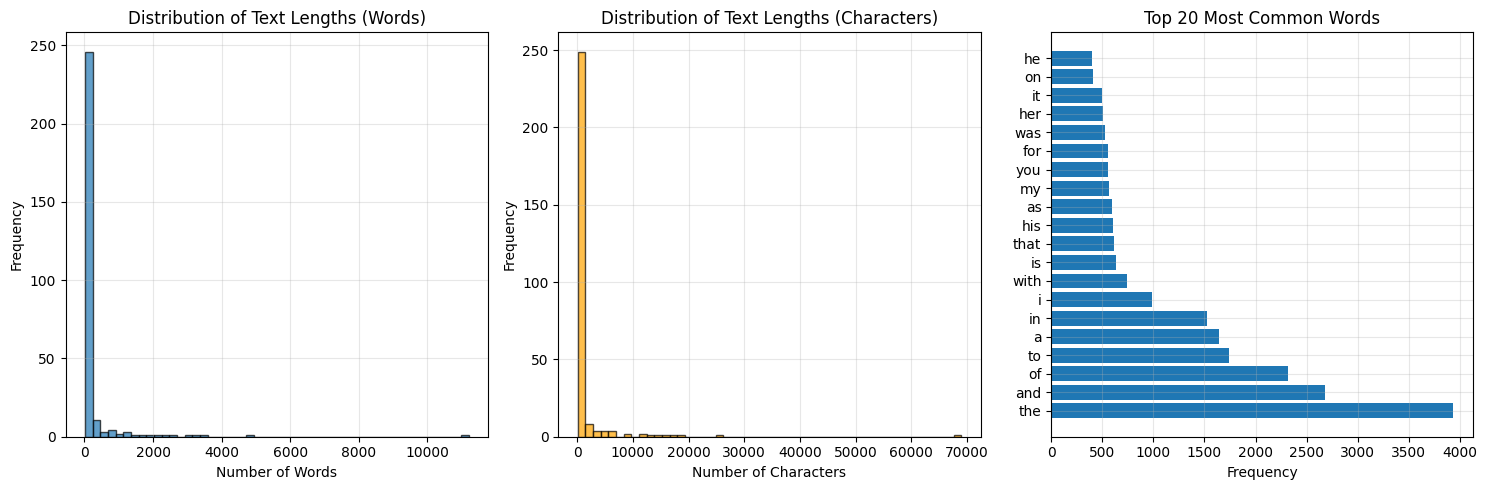


Preprocessing data...
Cleaning texts...
Kept 280 out of 280 texts after cleaning
Tokenizing texts...
Converting to sequences...
Creating training sequences...
Created 9894 training sequences
Padding sequences...
Final vocabulary size: 2800
Sequence length: 40
Training samples: 9894

Dataset Statistics:
Vocabulary size: 2800
Sequence length: 40
Training samples: 9894
Memory usage: ~212.8 MB

Building model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

Training configuration:
Batch size: 32
Epochs: 100
Estimated training time: 3090.0 seconds

Starting training...
Starting model training...
Training samples: 9894
Validation samples: 1484
Epoch 1/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.1146 - loss: 6.4670
Epoch 1: val_loss improved from inf to 6.16545, saving model to best_lstm_model.h5


263/263 ━━━━━━━━━━━━━━━━━━━━ 138s 449ms/step - accuracy: 0.1147 - loss: 6.4657 - val_accuracy: 0.1131 - val_loss: 6.1655 - learning_rate: 0.0010
Epoch 2/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.1299 - loss: 5.8090
Epoch 2: val_loss did not improve from 6.16545
263/263 ━━━━━━━━━━━━━━━━━━━━ 117s 446ms/step - accuracy: 0.1299 - loss: 5.8090 - val_accuracy: 0.1131 - val_loss: 6.2326 - learning_rate: 0.0010
Epoch 3/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.1299 - loss: 5.7598
Epoch 3: val_loss did not improve from 6.16545
263/263 ━━━━━━━━━━━━━━━━━━━━ 141s 440ms/step - accuracy: 0.1299 - loss: 5.7597 - val_accuracy: 0.1131 - val_loss: 6.2714 - learning_rate: 0.0010
Epoch 4/100
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.1299 - loss: 5.6686
Epoch 4: val_loss did not improve from 6.16545
263/263 ━━━━━━━━━━━━━━━━━━━━ 142s 440ms/step - accuracy: 0.1299 - loss: 5.6684 - val_accuracy: 0.1131 - val_loss: 6.3427 - learning_rate: 0.0010
Epoch 5/100


In [27]:
if __name__ == "__main__":
    print("🎵 LSTM LYRIC/POETRY GENERATOR")
    print("=" * 50)

    # Quick start guide
    colab_quick_start()

    print("\n" + "=" * 50)
    print("INTERACTIVE MODE")
    print("=" * 50)

    # Pilihan menu
    print("\nPilih mode:")
    print("1. 🏋️ Train new model")
    print("2. ✍️ Generate lyrics (requires trained model)")
    print("3. 📊 Evaluate model")
    print("4. 📈 Analyze dataset")
    print("5. 🎲 Generate multiple variations")

    try:
        choice = input("\nChoose option (1-5): ")

        if choice == "1":
            # Training mode
            data_path = input("Enter dataset path (or press Enter for default): ") or "/content/drive/MyDrive/Colab Notebooks/data"
            print(f"Starting training with data from: {data_path}")
            generator, preprocessor = main_training(data_path)
            if generator:
                print("✅ Training completed successfully!")

        elif choice == "2":
            # Generation mode
            seed = input("Enter seed text (or press Enter for 'love is'): ") or "love is"
            num_words = int(input("Number of words to generate (default 30): ") or 30)
            temperature = float(input("Temperature (0.5-2.0, default 0.8): ") or 0.8)

            result = generate_lyrics(seed, num_words, temperature)
            if result:
                print(f"\n🎵 Generated lyrics:")
                print("=" * 40)
                print(result)
                print("=" * 40)

        elif choice == "3":
            # Evaluation mode
            print("Starting model evaluation...")
            evaluate_model()

        elif choice == "4":
            # Analysis mode
            data_path = input("Enter dataset path (or press Enter for default): ") or "/content/drive/MyDrive/Colab Notebooks/data"
            print("Loading dataset for analysis...")
            texts = load_poems_dataset(data_path)
            if texts:
                analyze_dataset(texts)

        elif choice == "5":
            # Multiple variations mode
            seed = input("Enter seed text (or press Enter for 'love is'): ") or "love is"
            num_variations = int(input("Number of variations (default 5): ") or 5)
            num_words = int(input("Number of words per variation (default 25): ") or 25)

            generate_multiple_lyrics(seed, num_variations, num_words)

        else:
            print("❌ Invalid choice!")

    except KeyboardInterrupt:
        print("\n👋 Program interrupted by user")
    except Exception as e:
        print(f"❌ Error: {e}")
